# Data Loading And Preproces

In [1]:
!pip install datasets
!pip install ipywidgets==8.1.1



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [40]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import datasets
import matplotlib.pyplot as plt

In [3]:
from datasets import load_dataset
#datasets.config.DOWNLOAD_TIMEOUT = 120

dataset = load_dataset("opus100", "el-en")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/194k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/83.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/190k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
print(dataset["train"][1])

{'translation': {'el': '- Αν εσύ...', 'en': '- If you...'}}


In [5]:
dataset


DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [6]:
len(dataset['train']['translation'])

1000000

In [7]:
greek=[item['el'] for item in dataset['train']['translation'][:30000]]# I took smaler data set because it didn't load into colab
eng=[item['en'] for item in dataset['train']['translation'][:30000]]

In [8]:
greek=np.array(greek)
eng=np.array(eng)

In [9]:
len(greek)

30000

In [10]:
print(greek[1],"=",eng[1])

- Αν εσύ... = - If you...


In [11]:
type(greek)


numpy.ndarray

In [12]:
text_vect_en=tf.keras.layers.TextVectorization(max_tokens=10000,
                                               output_sequence_length=20,standardize='lower_and_strip_punctuation')
text_vect_en.adapt(eng)


text_vect_gr=tf.keras.layers.TextVectorization(max_tokens=10000,
                                               output_sequence_length=20,standardize='lower_and_strip_punctuation')
text_vect_gr.adapt([f'SOS {s} EOS' for s in greek])



In [13]:
text_vect_gr(greek[1])# it seems that i should use masking

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 66, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [14]:
text_vect_en.get_vocabulary()[:5]


['', '[UNK]', np.str_('the'), np.str_('you'), np.str_('to')]

In [15]:
text_vect_gr.get_vocabulary()[:5]

['', '[UNK]', np.str_('sos'), np.str_('eos'), np.str_('να')]

In [16]:
text_vect_gr.vocabulary_size()

10000

In [17]:
vocab_size_en=text_vect_en.vocabulary_size()
vocab_size_gr=text_vect_gr.vocabulary_size()

In [18]:
X_train_encoder=tf.constant(eng[:20000],dtype=tf.string)
X_valid_encoder=tf.constant(eng[20000:],dtype=tf.string)

X_train_decoder=tf.constant([f"SOS {s} " for s in greek[:20000]],dtype=tf.string)
X_valid_decoder=tf.constant([f"SOS {s} " for s in greek[20000:]],dtype=tf.string)

Y_train=[f" {s} EOS" for s in greek[:20000]]
Y_valid=[f" {s} EOS" for s in greek[20000:]]

In [19]:
type(X_train_decoder)

tensorflow.python.framework.ops.EagerTensor

In [20]:
text_vect_gr(X_train_decoder[1])

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([  2,  66, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [21]:
text_vect_gr(Y_train[1])

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 66, 103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

# Model_1

In [32]:
encoder_embedding=tf.keras.layers.Embedding(vocab_size_en,
                                            output_dim=10,
                                            mask_zero=False)
decoder_embedding=tf.keras.layers.Embedding(vocab_size_gr,
                                            output_dim=10,
                                            mask_zero=False)

In [33]:
encoder_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)
decoder_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)

encoder_vec=text_vect_en(encoder_inputs)
decoder_vec=text_vect_gr(decoder_inputs)

encoded_emb=encoder_embedding(encoder_vec)
decoded_emb=decoder_embedding(decoder_vec)

encoder=tf.keras.layers.LSTM(128,return_state=True,return_sequences=False)
encoder_outputs,*encoder_state=encoder(encoded_emb)



decoder=tf.keras.layers.LSTM(128,return_sequences=True)
decoder_outputs=decoder(decoded_emb,initial_state=encoder_state)

output_layer=tf.keras.layers.Dense(vocab_size_gr, activation='softmax')
Y_prob=output_layer(decoder_outputs)


In [34]:
Checkpoint=tf.keras.callbacks.ModelCheckpoint(
    'model_1.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr_schedule)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,verbose=1,restore_best_weights=True,mode='max')

model=tf.keras.Model(inputs=[encoder_inputs,decoder_inputs],outputs=[Y_prob])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
 metrics=["accuracy"])

In [35]:
Y_train_vec=text_vect_gr(Y_train)
Y_valid_vec=text_vect_gr(Y_valid)

In [36]:
decoder_outputs.shape

(None, 20, 128)

In [37]:
encoder_outputs.shape

(None, 128)

In [38]:
history_1 = model.fit((X_train_encoder, X_train_decoder), Y_train_vec,
                      validation_data=((X_valid_encoder, X_valid_decoder), Y_valid_vec),
                      epochs=100, callbacks=[Checkpoint,early_stop])


Epoch 1/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6843 - loss: 2.6601
Epoch 1: val_accuracy improved from -inf to 0.71455, saving model to model_1.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.6844 - loss: 2.6584 - val_accuracy: 0.7146 - val_loss: 2.0273
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7295 - loss: 1.8679
Epoch 2: val_accuracy improved from 0.71455 to 0.71694, saving model to model_1.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.7295 - loss: 1.8678 - val_accuracy: 0.7169 - val_loss: 1.9587
Epoch 3/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7364 - loss: 1.7493
Epoch 3: val_accuracy improved from 0.71694 to 0.71970, saving model to model_1.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.7364 - loss: 1.7493 - val_accuracy: 0.7197 - val_loss: 1.9080
Epoch 4/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7347 - loss: 1.6970
Epoch 4: val_accuracy improved from 

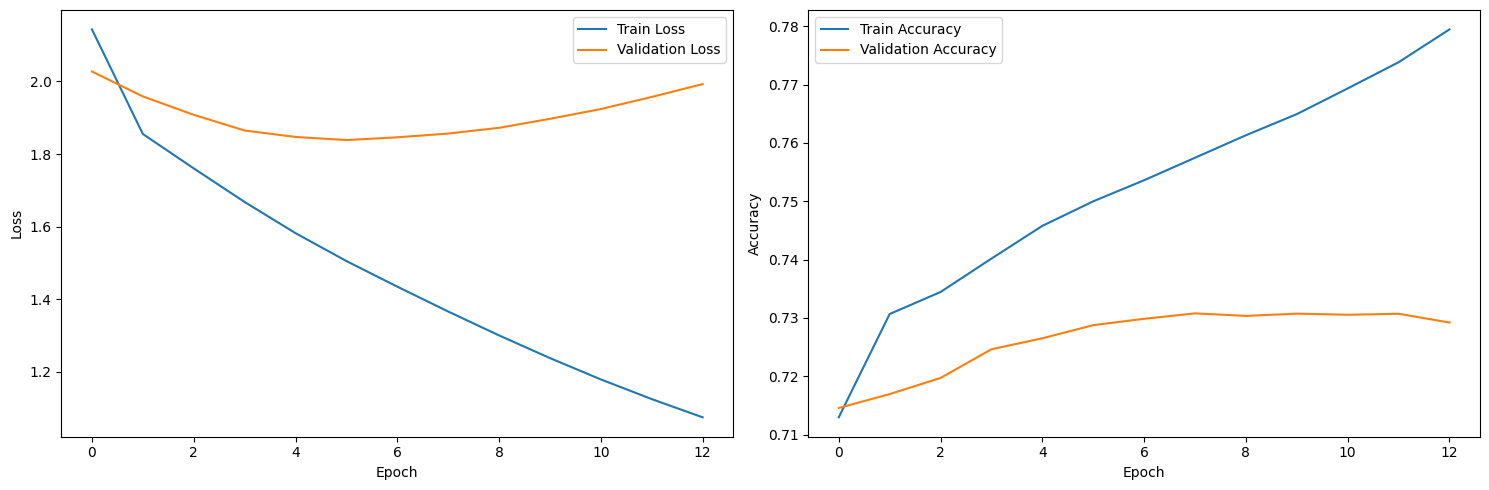

In [41]:
fig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history_1.history['loss'],label='Train Loss')
axes[0].plot(history_1.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_1.history['accuracy'],label='Train Accuracy')
axes[1].plot(history_1.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()